# 0.0 IMPORTS 

In [53]:
import warnings
import numpy as np 
import pandas as pd  
import seaborn as sns

import plotly.express as px 
import matplotlib.dates as mdates
from matplotlib import pyplot as plt 

sns.set()
warnings.filterwarnings( 'ignore' )
pd.set_option('display.max_columns', None) 
pd.set_option('display.float_format', lambda x: '%.2f' %x )

# 0.1 FUNÇÕES AUXILIARES

In [2]:
def choose_season(line): 
    if line.month == 6 or line.month == 7 or line.month == 8: 
        return 'summer'
    elif line.month == 9 or line.month == 10 or line.month == 11: 
        return 'autumn' 
    elif line.month == 12 or line.month == 1 or line.month == 2: 
        return 'winter' 
    else: 
        return 'spring'
    
def outlier(df, column, h=5, asc=False):  
    boxplot = sns.boxplot(data = df[[column]]); 
    sorted_values = df.sort_values(column,ascending=asc).head(h) 
    return sorted_values

def variance_percentage(previous_value, current_value):
    variance = current_value - previous_value
    variance_percentage = (variance / previous_value) * 100
    return round(variance_percentage, 2) 

# 0.2 CARREGANDO DADOS

In [3]:
data = pd.read_csv('data/kc_house_data.csv')
data_address = pd.read_csv('data/address.csv')
data = pd.merge(data, data_address, on='id', how='inner').drop(columns=['query'],axis=1)

Obs: As informações de endereço dessas propriedades foram coletadas usando o módulo criado: address.py É importante citar que todas as propriedades estão localizadas em Seattle, EUA, portanto, apenas o nome da rua e o número da propriedade foram coletados. Alguns imóveis apresentarão valores NaN em seus endereços, pois para essas propriedades essa informação não estava disponível.

# 1.0. PASSO 1 - DESCRIÇÃO E LIMPEZA DOS DADOS

## 1.1 Dimensões da base de dados

In [4]:
print('Número de Linhas: {}'.format(data.shape[0]))
print('Número de Colunas: {}'.format(data.shape[1]))

Número de Linhas: 21599
Número de Colunas: 23


## 1.2 Tipo de Dados

In [5]:
data.dtypes

id                 int64
date              object
price            float64
bedrooms           int64
bathrooms        float64
sqft_living        int64
sqft_lot           int64
floors           float64
waterfront         int64
view               int64
condition          int64
grade              int64
sqft_above         int64
sqft_basement      int64
yr_built           int64
yr_renovated       int64
zipcode            int64
lat              float64
long             float64
sqft_living15      int64
sqft_lot15         int64
road              object
house_number      object
dtype: object

In [6]:
#verificando número de zeros por coluna 
for column_name in data.columns: 
    column = data[column_name]
    count = column[column == 0].count()
    print(f'O número de zeros da coluna {column_name} é: {count}')

O número de zeros da coluna id é: 0
O número de zeros da coluna date é: 0
O número de zeros da coluna price é: 0
O número de zeros da coluna bedrooms é: 0
O número de zeros da coluna bathrooms é: 3
O número de zeros da coluna sqft_living é: 0
O número de zeros da coluna sqft_lot é: 0
O número de zeros da coluna floors é: 0
O número de zeros da coluna waterfront é: 21436
O número de zeros da coluna view é: 19477
O número de zeros da coluna condition é: 0
O número de zeros da coluna grade é: 0
O número de zeros da coluna sqft_above é: 0
O número de zeros da coluna sqft_basement é: 13113
O número de zeros da coluna yr_built é: 0
O número de zeros da coluna yr_renovated é: 20685
O número de zeros da coluna zipcode é: 0
O número de zeros da coluna lat é: 0
O número de zeros da coluna long é: 0
O número de zeros da coluna sqft_living15 é: 0
O número de zeros da coluna sqft_lot15 é: 0
O número de zeros da coluna road é: 0
O número de zeros da coluna house_number é: 0


# 1.3 Alterando Tipos

In [7]:
#data para datetime
data['date'] = pd.to_datetime(data['date'])

#deixando a coluna yr_renovated toda em datetime 
data['yr_renovated'] = data['yr_renovated'].apply(lambda x: pd.to_datetime(1900, format = '%Y') if x == 0 else pd.to_datetime(x, format = '%Y'))

#yr_built para datetime 
data['yr_built'] = pd.to_datetime(data['yr_built'], format = '%Y')

In [8]:
data.dtypes

id                        int64
date             datetime64[ns]
price                   float64
bedrooms                  int64
bathrooms               float64
sqft_living               int64
sqft_lot                  int64
floors                  float64
waterfront                int64
view                      int64
condition                 int64
grade                     int64
sqft_above                int64
sqft_basement             int64
yr_built         datetime64[ns]
yr_renovated     datetime64[ns]
zipcode                   int64
lat                     float64
long                    float64
sqft_living15             int64
sqft_lot15                int64
road                     object
house_number             object
dtype: object

## 1.3 Verificando valores NA

In [9]:
data.isna().sum()

id                  0
date                0
price               0
bedrooms            0
bathrooms           0
sqft_living         0
sqft_lot            0
floors              0
waterfront          0
view                0
condition           0
grade               0
sqft_above          0
sqft_basement       0
yr_built            0
yr_renovated        0
zipcode             0
lat                 0
long                0
sqft_living15       0
sqft_lot15          0
road              201
house_number     1083
dtype: int64

os valores nulos acima, correspondem aos endereços não disponíves

In [10]:
#preenchendo valores NA 

data['road'] = data['road'].fillna('undefined')
data['house_number'] = data['house_number'].fillna('undefined')

# 1.4 checando ID's duplicados

In [12]:
data['id'].value_counts()

795000620     3
8651510380    2
2568300045    2
9353300600    2
4139480200    2
             ..
2767603649    1
1446403617    1
5602000275    1
1786200010    1
1523300157    1
Name: id, Length: 21422, dtype: int64

In [13]:
#apagando id's duplicados
data.drop_duplicates(subset=['id'], inplace=True, keep='first') 

In [14]:
print('Número de Linhas: {}'.format(data.shape[0]))
print('Número de Colunas: {}'.format(data.shape[1]))

Número de Linhas: 21422
Número de Colunas: 23


# 1.5 Estatística Descritiva

In [15]:
data_numeric = data.select_dtypes(include=['float64', 'int64'])
data_numeric = data_numeric.drop(['id', 'waterfront'], axis = 1) 
data_numeric.describe() 

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,view,condition,grade,sqft_above,sqft_basement,zipcode,lat,long,sqft_living15,sqft_lot15
count,21422.00,21422.00,21422.00,21422.00,21422.00,21422.00,21422.00,21422.00,21422.00,21422.00,21422.00,21422.00,21422.00,21422.00,21422.00,21422.00
mean,540604.16,3.37,2.12,2082.95,15130.60,1.50,0.24,3.41,7.66,1791.05,291.91,98077.87,47.56,-122.21,1988.32,12778.26
std,367696.64,0.90,0.77,918.92,41529.35,0.54,0.77,0.65,1.17,828.75,442.86,53.48,0.14,0.14,685.55,27345.18
min,75000.00,1.00,0.00,370.00,520.00,1.00,0.00,1.00,3.00,370.00,0.00,98001.00,47.16,-122.52,399.00,651.00
25%,322500.00,3.00,1.75,1430.00,5040.00,1.00,0.00,3.00,7.00,1200.00,0.00,98033.00,47.47,-122.33,1490.00,5100.00
50%,450000.00,3.00,2.25,1920.00,7615.00,1.50,0.00,3.00,7.00,1560.00,0.00,98065.00,47.57,-122.23,1840.00,7620.00
75%,645000.00,4.00,2.50,2550.00,10696.75,2.00,0.00,4.00,8.00,2220.00,560.00,98117.00,47.68,-122.12,2370.00,10087.75
max,7700000.00,11.00,8.00,13540.00,1651359.00,3.50,4.00,5.00,13.00,9410.00,4820.00,98199.00,47.78,-121.31,6210.00,871200.00


# 1.6 Verificação de Outliers

## 1.6.1 Colune Price

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,road,house_number
7247,6762700020,2014-10-13,7700000.00,6,8.00,12050,27600,2.50,0,3,4,13,8570,3480,1910-01-01,1987-01-01,98102,47.63,-122.32,3940,8800,Harvard Avenue East,1137
3911,9808700762,2014-06-11,7062500.00,5,4.50,10040,37325,2.00,1,2,3,11,7680,2360,1940-01-01,2001-01-01,98004,47.65,-122.21,3930,25449,95th Avenue Northeast,undefined
9247,9208900037,2014-09-19,6885000.00,6,7.75,9890,31374,2.00,0,4,3,13,8860,1030,2001-01-01,1900-01-01,98039,47.63,-122.24,4540,42730,Laurel Lane,undefined
4408,2470100110,2014-08-04,5570000.00,5,5.75,9200,35069,2.00,0,0,3,13,6200,3000,2001-01-01,1900-01-01,98039,47.63,-122.23,3560,24345,Northeast 12th Street,undefined
1447,8907500070,2015-04-13,5350000.00,5,5.00,8000,23985,2.00,0,4,3,12,6720,1280,2009-01-01,1900-01-01,98004,47.62,-122.22,4600,21750,Northeast 14th Street,9045
1314,7558700030,2015-04-13,5300000.00,6,6.00,7390,24829,2.00,1,4,4,12,5000,2390,1991-01-01,1900-01-01,98040,47.56,-122.21,4320,24619,4600 Block,undefined
1163,1247600105,2014-10-20,5110800.00,5,5.25,8010,45517,2.00,1,4,3,12,5990,2020,1999-01-01,1900-01-01,98033,47.68,-122.21,3430,26788,Lake Avenue West,137
8087,1924059029,2014-06-17,4668000.00,5,6.75,9640,13068,1.00,1,4,3,12,4820,4820,1983-01-01,2009-01-01,98040,47.56,-122.21,3270,10454,Southeast 52nd Street,undefined
2625,7738500731,2014-08-15,4500000.00,5,5.50,6640,40014,2.00,1,4,3,12,6350,290,2004-01-01,1900-01-01,98155,47.75,-122.28,3030,23408,Shore Drive Northeast,16714
8631,3835500195,2014-06-18,4489000.00,4,3.00,6430,27517,2.00,0,0,3,12,6430,0,2001-01-01,1900-01-01,98004,47.62,-122.22,3720,14592,91st Avenue Northeast,1195


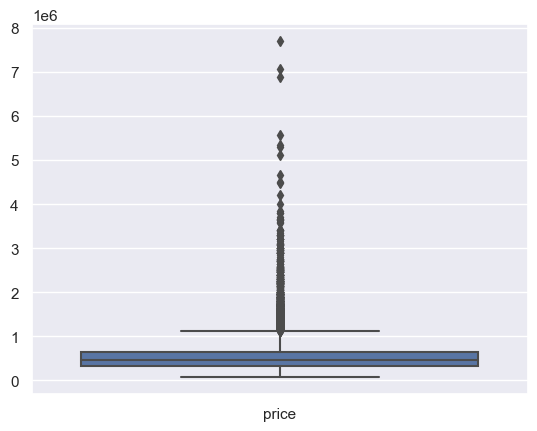

In [16]:
outlier(data, 'price', h=15)

No que diz respeito ao preço, nenhum desses registros apresenta valores discrepantes, visto que os preços correspondem às características dos imóveis. 

## 1.6.2 Coluna bedrooms

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,road,house_number
8750,1773100755,20140821T000000,520000.00,11,3.00,3000,4960,2.00,0,0,3,7,2400,600,1918,1999,98106,47.56,-122.36,1420,4960,Delridge Way Southwest,5055
15150,5566100170,20141029T000000,650000.00,10,2.00,3610,11914,2.00,0,0,4,7,3010,600,1958,0,98006,47.57,-122.17,2040,11914,Southeast 42nd Street,12353
19241,8812401450,20141229T000000,660000.00,10,3.00,2920,3745,2.00,0,0,4,7,1860,1060,1913,0,98105,47.66,-122.32,1810,3745,8th Avenue Northeast,4711
13304,627300145,20140814T000000,1148000.00,10,5.25,4590,10920,1.00,0,2,3,9,2500,2090,2008,0,98004,47.59,-122.11,2730,10400,Southeast 26th Street,17079
4093,1997200215,20140507T000000,599999.00,9,4.50,3830,6988,2.50,0,0,3,7,2450,1380,1938,0,98103,47.69,-122.34,1460,6291,Densmore Avenue North,8809
6075,9822700190,20140808T000000,1280000.00,9,4.50,3650,5000,2.00,0,0,3,8,2530,1120,1915,2010,98105,47.66,-122.29,2510,5000,36th Avenue Northeast,4316
18430,8823901445,20150313T000000,934000.00,9,3.00,2820,4480,2.00,0,0,3,7,1880,940,1918,0,98105,47.67,-122.31,2460,4400,19th Avenue Northeast,5016
4232,2902200015,20150106T000000,700000.00,9,3.00,3680,4400,2.00,0,0,3,7,2830,850,1908,0,98102,47.64,-122.32,1960,2450,Franklin Avenue East,2014
8539,424049043,20140811T000000,450000.00,9,7.50,4050,6504,2.00,0,0,3,7,4050,0,1996,0,98144,47.59,-122.30,1448,3866,24th Avenue South,1122
16832,8823900290,20150317T000000,1400000.00,9,4.00,4620,5508,2.50,0,0,3,11,3870,750,1915,0,98105,47.67,-122.31,2710,4320,17th Avenue Northeast,5270


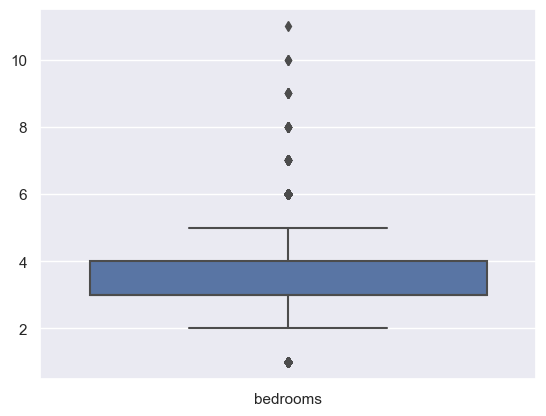

In [40]:
outlier(data, 'bedrooms', h=15)

O registro de um imóvel com 33 quartos foi considerado um erro de digitação, pois espera-se um imóvel nessas condições certamente seria mais caro do que U$ 640000.00 e ter mais que 1620 m² de área.

In [17]:
data = data.loc[(data['bedrooms']!= 33)]

## 1.6.3 Coluna bathrooms

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,road,house_number
12767,1225069038,20140505T000000,2280000.00,7,8.00,13540,307752,3.00,0,4,3,12,9410,4130,1999,0,98053,47.67,-121.99,4850,217800,Northeast 70th Street,26408
7247,6762700020,20141013T000000,7700000.00,6,8.00,12050,27600,2.50,0,3,4,13,8570,3480,1910,1987,98102,47.63,-122.32,3940,8800,Harvard Avenue East,1137
9247,9208900037,20140919T000000,6885000.00,6,7.75,9890,31374,2.00,0,4,3,13,8860,1030,2001,0,98039,47.63,-122.24,4540,42730,Laurel Lane,NaN
8539,424049043,20140811T000000,450000.00,9,7.50,4050,6504,2.00,0,0,3,7,4050,0,1996,0,98144,47.59,-122.30,1448,3866,24th Avenue South,1122
4021,9175600025,20141007T000000,800000.00,7,6.75,7480,41664,2.00,0,2,3,11,5080,2400,1953,0,98166,47.46,-122.37,2810,33190,Southwest 156th Street,2700
8087,1924059029,20140617T000000,4668000.00,5,6.75,9640,13068,1.00,1,4,3,12,4820,4820,1983,2009,98040,47.56,-122.21,3270,10454,Southeast 52nd Street,NaN
20564,424069279,20150328T000000,1180000.00,6,6.50,6260,10955,2.00,0,0,3,11,4840,1420,2007,0,98075,47.59,-122.04,2710,12550,Southeast 16th Place,22541
21492,2524069097,20140509T000000,2238890.00,5,6.50,7270,130017,2.00,0,0,3,12,6420,850,2010,0,98027,47.54,-121.98,1800,44890,270th Place Southeast,7099
14545,2303900035,20140611T000000,2888000.00,5,6.25,8670,64033,2.00,0,4,3,13,6120,2550,1965,2003,98177,47.73,-122.37,4140,81021,Northwest Elford Drive,1291
18290,6072800246,20140702T000000,3300000.00,5,6.25,8020,21738,2.00,0,0,3,11,8020,0,2001,0,98006,47.57,-122.19,4160,18969,Crescent Key,6


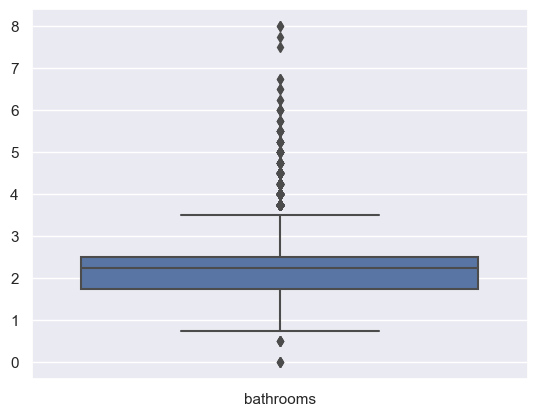

In [41]:
outlier(data, 'bathrooms', h=15)

nenhum desses registros apresenta valores discrepantes, visto que correspondem às características dos imóveis.

## 1.6.4 Coluna sqft_living

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,road,house_number
12767,1225069038,20140505T000000,2280000.00,7,8.00,13540,307752,3.00,0,4,3,12,9410,4130,1999,0,98053,47.67,-121.99,4850,217800,Northeast 70th Street,26408
7247,6762700020,20141013T000000,7700000.00,6,8.00,12050,27600,2.50,0,3,4,13,8570,3480,1910,1987,98102,47.63,-122.32,3940,8800,Harvard Avenue East,1137
3911,9808700762,20140611T000000,7062500.00,5,4.50,10040,37325,2.00,1,2,3,11,7680,2360,1940,2001,98004,47.65,-122.21,3930,25449,95th Avenue Northeast,NaN
9247,9208900037,20140919T000000,6885000.00,6,7.75,9890,31374,2.00,0,4,3,13,8860,1030,2001,0,98039,47.63,-122.24,4540,42730,Laurel Lane,NaN
8087,1924059029,20140617T000000,4668000.00,5,6.75,9640,13068,1.00,1,4,3,12,4820,4820,1983,2009,98040,47.56,-122.21,3270,10454,Southeast 52nd Street,NaN
4408,2470100110,20140804T000000,5570000.00,5,5.75,9200,35069,2.00,0,0,3,13,6200,3000,2001,0,98039,47.63,-122.23,3560,24345,Northeast 12th Street,NaN
14545,2303900035,20140611T000000,2888000.00,5,6.25,8670,64033,2.00,0,4,3,13,6120,2550,1965,2003,98177,47.73,-122.37,4140,81021,Northwest Elford Drive,1291
18290,6072800246,20140702T000000,3300000.00,5,6.25,8020,21738,2.00,0,0,3,11,8020,0,2001,0,98006,47.57,-122.19,4160,18969,Crescent Key,6
1163,1247600105,20141020T000000,5110800.00,5,5.25,8010,45517,2.00,1,4,3,12,5990,2020,1999,0,98033,47.68,-122.21,3430,26788,Lake Avenue West,137
1447,8907500070,20150413T000000,5350000.00,5,5.00,8000,23985,2.00,0,4,3,12,6720,1280,2009,0,98004,47.62,-122.22,4600,21750,Northeast 14th Street,9045


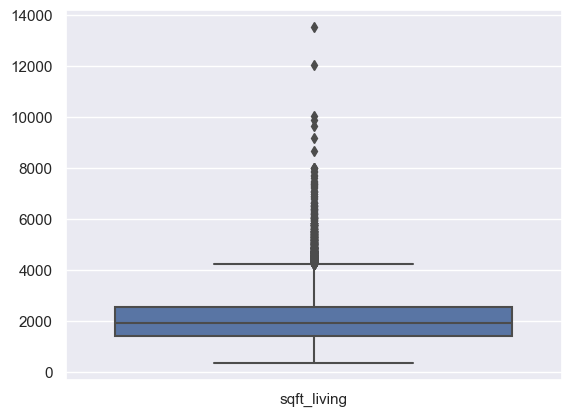

In [42]:
outlier(data, 'sqft_living', h=15)

nenhum desses registros apresenta valores discrepantes, visto que os preços correspondem às características dos imóveis.

## 1.6.3 Coluna sqft_lot

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,road,house_number
1718,1020069017,20150327T000000,700000.00,4,1.00,1300,1651359,1.00,0,3,4,6,1300,0,1920,0,98022,47.23,-122.02,2560,425581,236th Avenue Southeast,41226
17307,3326079016,20150504T000000,190000.00,2,1.00,710,1164794,1.00,0,0,2,5,710,0,1915,0,98014,47.69,-121.91,1680,16730,Kelly Road Northeast,10001
7642,2623069031,20140521T000000,542500.00,5,3.25,3010,1074218,1.50,0,0,5,8,2010,1000,1931,0,98027,47.46,-122.00,2450,68825,252nd Avenue Southeast,16206
7764,2323089009,20150119T000000,855000.00,4,3.50,4030,1024068,2.00,0,0,3,10,4030,0,2006,0,98045,47.46,-121.74,1830,11700,NaN,NaN
3946,722069232,20140905T000000,998000.00,4,3.25,3770,982998,2.00,0,0,3,10,3770,0,1992,0,98058,47.41,-122.09,2290,37141,Southeast 209th Place,19115
4438,3626079040,20140730T000000,790000.00,2,3.00,2560,982278,1.00,0,0,3,8,2560,0,2004,0,98014,47.70,-121.86,1620,40946,Northeast Moss Lake Road,NaN
6687,2624089007,20150320T000000,1998000.00,2,2.50,3900,920423,2.00,0,0,3,12,3900,0,2009,0,98065,47.54,-121.76,2720,411962,North Fork Road Southeast,NaN
7072,2724079090,20150105T000000,1650000.00,4,3.25,3920,881654,3.00,0,3,3,11,3920,0,2002,0,98024,47.54,-121.90,2970,112384,Lake Alice Road Southeast,NaN
20438,1125079111,20150415T000000,1600000.00,4,5.50,6530,871200,2.00,0,2,3,11,6530,0,2008,0,98014,47.66,-121.88,1280,858132,Tolt Highlands Northeast Road,NaN
9707,225079036,20150107T000000,937500.00,4,4.00,5545,871200,2.00,0,0,3,11,3605,1940,2003,0,98014,47.68,-121.88,3420,871200,Tolt Highlands Northeast Road,9010


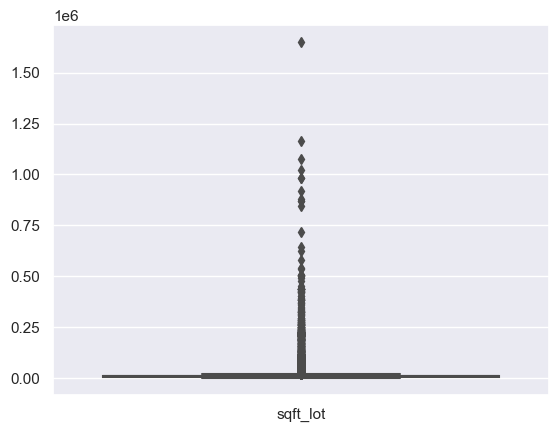

In [43]:
outlier(data, 'sqft_lot', h=15)

nenhum desses registros apresenta valores discrepantes, visto que os preços correspondem às características dos imóveis.

# 2.0 Feature Engineering

In [18]:
#casa renovada ou não? 
data['renovated'] = data.apply(lambda line: 'no' if line['yr_renovated'] == pd.to_datetime(1900, format = '%Y') else 'yes', axis = 1)

#ano de compra
data['year'] = data['date'].dt.year

#estação do ano 
data['season'] = data['date'].apply(lambda x: choose_season(x))

#casa com porão ou não? 
data['basement'] = data['sqft_basement'].apply(lambda line: line if line == 0 else 1) 

# 3.0 Validação de Hipóteses

## H1 Imóveis que possuem vista para água, são 30% mais caros, na média. 

Falso! Imóveis que possuem vista pra água são, em média 212.6% mais caros. 

In [85]:
water_front_median

,waterfront,price
0,0,531632.57
1,1,1661876.02


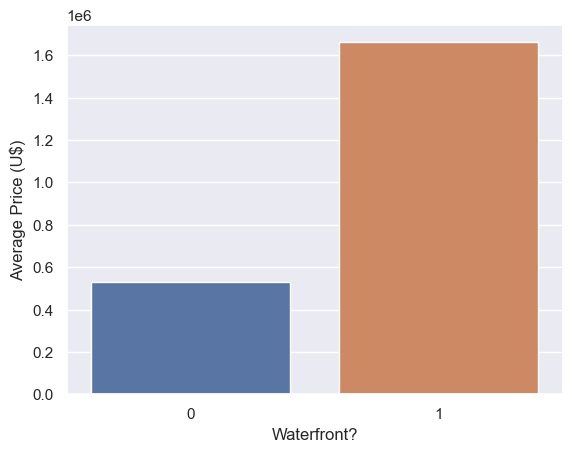

In [32]:
water_front_median = data[['price', 'waterfront']].groupby('waterfront').mean().reset_index() 

graph = sns.barplot(data = water_front_median, x='waterfront', y ='price');

graph.set_xlabel("Waterfront?")
graph.set_ylabel("Average Price (U$)")

graph;

In [129]:
variance_percentage(water_front_median.loc[0, 'price'], water_front_median.loc[1, 'price'])

212.6

## H2 Imóveis com data de construção menor que 1955, são 50% mais baratos, na média.

Falso! Imóveis  com data de construção menor que 1955, são 1.09% mais caros. 

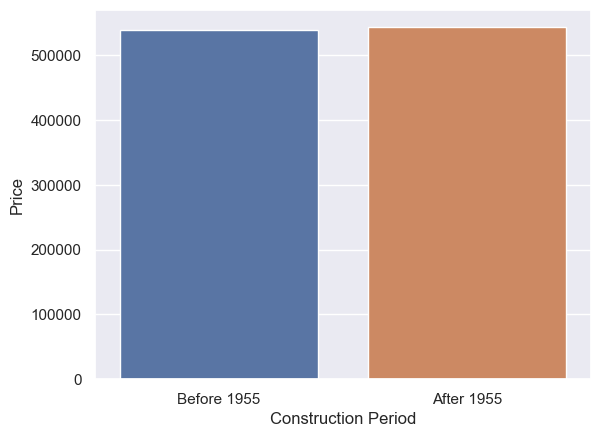

In [27]:
dt_before_1955 = data[data['yr_built'] < pd.to_datetime(1955, format = '%Y')]['price'].mean() 
dt_after_1955 = data[data['yr_built'] > pd.to_datetime(1955, format = '%Y')]['price'].mean() 

h2 = {
    'Construction Period': ['Before 1955', 'After 1955'],
    'Price': [dt_before_1955, dt_after_1955]
}

yr_built_1955 = pd.DataFrame(h2, index = [0, 1])

sns.barplot(data = yr_built_1955, x = 'Construction Period', y = 'Price');

In [130]:
variance_percentage(dt_before_1955, dt_after_1955)

1.09

## H3 Imóveis sem porão são 50% maiores do que com porão.

Falso! Imóveis com porão, são 19.82% maiores que sem porão

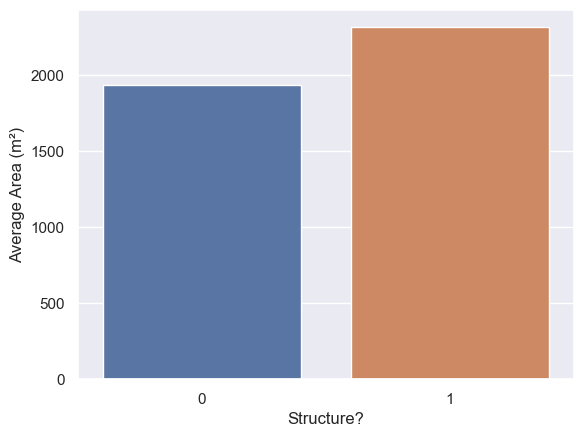

In [34]:
basement = data[['basement', 'sqft_living']].groupby('basement').mean().reset_index()

graph = sns.barplot(data = basement, x='basement', y='sqft_living') 

graph.set_xlabel("Structure?")
graph.set_ylabel("Average Area (m²)")

graph;

In [139]:
variance_percentage(basement.loc[0, 'sqft_living'], basement.loc[1, 'sqft_living'])

19.82

## H4 O crescimento do preço dos imóveis YoY ( Year over Year ) é de 10%

Falso! O crescimento do preço dos imóveis YoY é de 0.72%. 

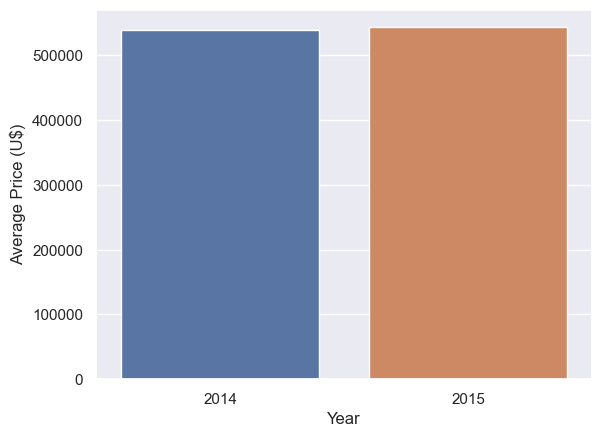

In [36]:
price_date = data[['price', 'year']].groupby('year').mean().reset_index()

graph = sns.barplot(data = price_date, x='year', y='price')

graph.set_xlabel("Year")
graph.set_ylabel("Average Price (U$)")

graph; 

In [142]:
variance_percentage(price_date.loc[0, 'price'], price_date.loc[1, 'price'])

0.72

## H5: Imóveis com 3 banheiros tem um crescimento MoM ( Month over Month ) de 15%

Falso! O crescimento MoM de casas com 3 banheiros não segue um padrão. 

In [48]:
mom_3_bathrooms = data.loc[data['bathrooms'] == 3, ['price', 'date']]

mom_3_bathrooms['date'] = pd.to_datetime(mom_3_bathrooms['date'].dt.strftime('%m-%Y'))

mom_3_bathrooms = mom_3_bathrooms.groupby('date').mean().reset_index()

mom_3_bathrooms['percentage change'] = mom_3_bathrooms['price'].pct_change() * 100

mom_3_bathrooms['variation sign'] =  mom_3_bathrooms['percentage change'].apply(lambda x: 'positive' if x > 0 else 'negative')

In [47]:
#gráfico de variação de preço 
graph4_1 = px.line(mom_3_bathrooms, x='date', y='price', labels={"date": "Month/Year", "price": "Average Price (U$)"})
graph4_1

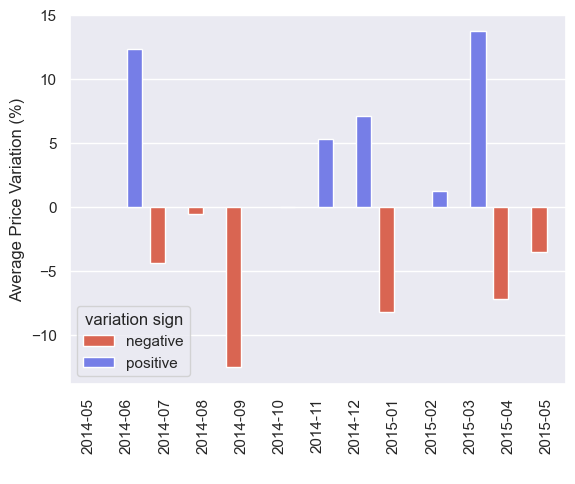

In [66]:
# gráfico de variação percentual 
graph = sns.barplot(data=mom_3_bathrooms, x='date', y='percentage change', hue='variation sign',
            palette={'negative': '#EF553B', 'positive': '#636EFA'})

#definindo nome pros rótulos
plt.xlabel(" ")
plt.ylabel("Average Price Variation (%)")
plt.xticks(rotation=90);

# Convertendo as datas para o formato ANO-MÊS
month_names = [pd.to_datetime(m, format="%Y-%m").strftime("%Y-%m") for m in mom_3_bathrooms['date']]

# Alterando os rótulos do eixo x para os nomes dos meses no formato ANO-MÊS
graph.set_xticklabels(month_names, rotation=90)

plt.show()

## H6: Imóveis reformados a partir do ano 2000 são, em média, 25% mais caros.

Falso! Imóveis reformados a partir do ano 200, são em média, 43,22 % mais caros

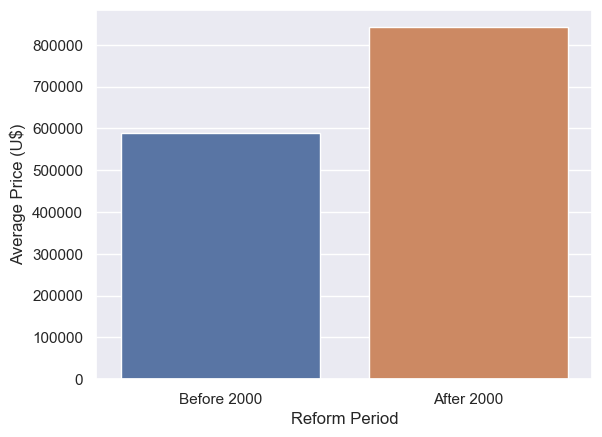

In [68]:
yr_renovated_price = data[['yr_renovated', 'price']].groupby('yr_renovated').mean().reset_index()
yr_renovated_price = yr_renovated_price.drop(yr_renovated_price[yr_renovated_price['yr_renovated'] == pd.to_datetime(1900, format='%Y')].index)

price_before_2000 = yr_renovated_price[yr_renovated_price['yr_renovated'] < pd.to_datetime(2000, format='%Y')]
price_after_2000 = yr_renovated_price[yr_renovated_price['yr_renovated'] >= pd.to_datetime(2000, format='%Y')]

column_1 = ['Before 2000', 'After 2000']
column_2 = [price_before_2000['price'].mean(), price_after_2000['price'].mean()]

yr_renovated_price = {'Reform Period': column_1, 'Average Price (U$)': column_2}

yr_renovated_price = pd.DataFrame(yr_renovated_price)

graph = sns.barplot(data = yr_renovated_price, x='Reform Period', y='Average Price (U$)')
graph;

In [149]:
variance_percentage(price_before_2000['price'].mean(), price_after_2000['price'].mean())

43.22

## H7: Imóveis com até 2 quartos são, em média, 20% mais baratos.

Falso! Imóveis com até 2 quartos, são em média 37,23% mais baratos

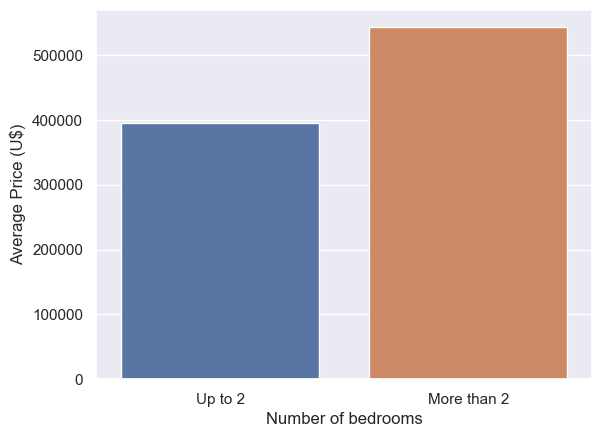

In [70]:
bedroom_smallest_2 = data[data['bedrooms'] <= 2]['price'].mean()
bedroom_larger_2 = data[data['bedrooms'] >= 2]['price'].mean()

column_0 = ['Up to 2', 'More than 2']
column_1 = [bedroom_smallest_2, bedroom_larger_2]

number_bedrooms_price = {'Number of bedrooms': column_0, 'Average Price (U$)': column_1}
number_bedrooms_price = pd.DataFrame(number_bedrooms_price)

graph = sns.barplot(data = number_bedrooms_price, x='Number of bedrooms', y='Average Price (U$)')
graph;

In [152]:
variance_percentage(bedroom_smallest_2, bedroom_larger_2)

37.23

# H8: Propriedades reformadas são 40% mais caras que não reformadas. 

Verdadeiro! Propriedades reformadas são, em média, 43% mais caras que não reformadas

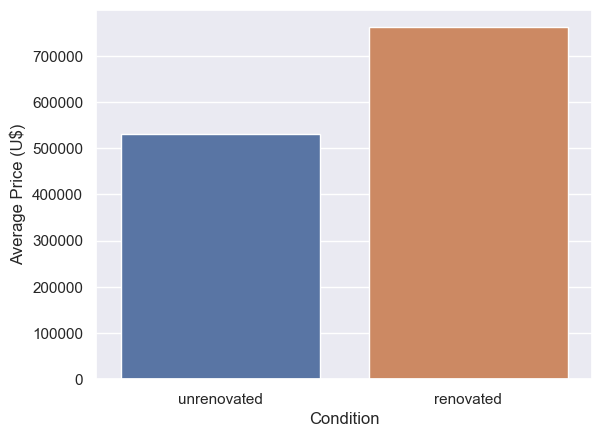

In [72]:
unrenovated_price = data[data['yr_renovated'] == pd.to_datetime('1900', format='%Y')]['price'].mean()
renovated_price = data[data['yr_renovated'] != pd.to_datetime('1900', format='%Y')]['price'].mean()

column_0 = ['unrenovated', 'renovated']
column_1 = [unrenovated_price, renovated_price]

reform = {'Condition': column_0, 'Average Price (U$)': column_1}
reform = pd.DataFrame(reform)

graph = sns.barplot(data = reform, x='Condition', y='Average Price (U$)')
graph;

In [157]:
variance_percentage(unrenovated_price, renovated_price)

43.51

# H9: A melhor estação do ano para comprar imóveis é no inverno, que é 20% mais barato que no resto do ano.

É verdade que o inverno é a melhor estação do ano para comprar imóveis, porém os imóveis ficam 4,85% mais baratos nesse período.

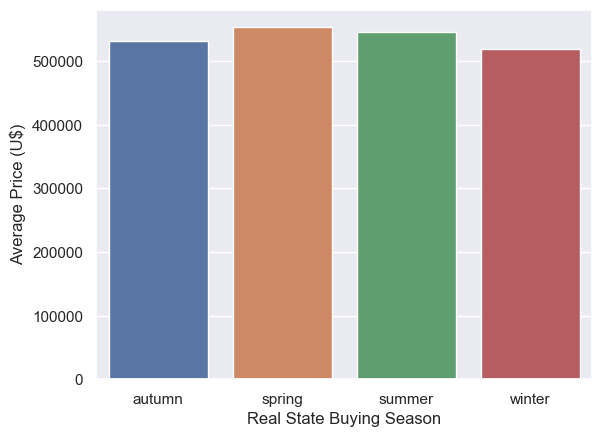

In [73]:
#Qual estação do ano é melhor?

season_price = data[['season', 'price']].groupby('season').mean().reset_index()

graph = sns.barplot(data = season_price, x='season', y='price')

graph.set_xlabel("Real State Buying Season")
graph.set_ylabel("Average Price (U$)")

graph;

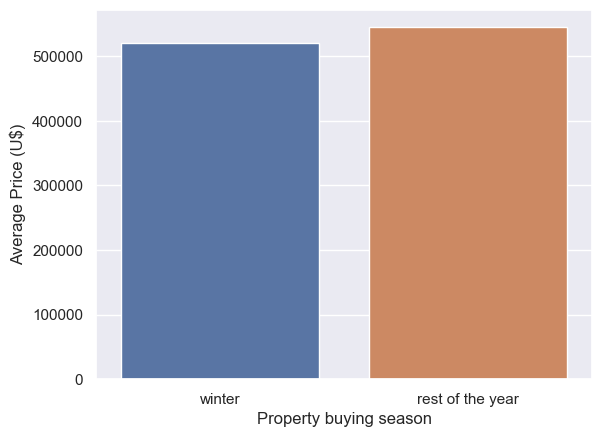

In [78]:
#Em qual porcentagem?
price_winter = data[data['season'] == 'winter']['price'].mean()
price_rest_of_the_year = data[data['season'] != 'winter']['price'].mean()

coluna_0 = ['winter', 'rest of the year']
coluna_1 = [price_winter, price_rest_of_the_year]

winter = {'Property buying season': coluna_0, 'Average Price (U$)': coluna_1}
winter = pd.DataFrame(winter)

graph = sns.barplot(data = winter, x='Property buying season', y='Average Price (U$)')

In [162]:
variance_percentage(price_winter, price_rest_of_the_year)

4.82

## H10: Imóveis com melhores condições são em média 20% mais caros 

Falso! Imóveis com melhores condições são em média 0.46% mais caros

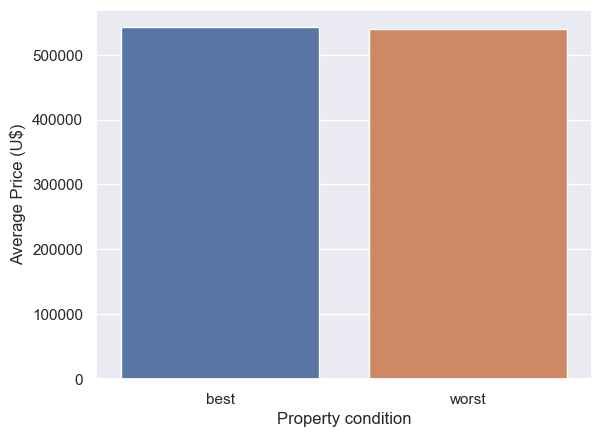

In [79]:
best_conditions = data[(data['condition'] == 4) | (data['condition'] == 5)]['price'].mean()
worst_conditions = data[(data['condition'] != 4) & (data['condition'] != 5)]['price'].mean()

column_0 = ['best', 'worst']
column_1 = [best_conditions, worst_conditions]

conditions = {'Property condition': column_0, 'Average Price (U$)': column_1}
conditions = pd.DataFrame(conditions)

graph = sns.barplot(data = conditions, x='Property condition', y='Average Price (U$)')

In [168]:
variance_percentage(worst_conditions, best_conditions)

0.46

# 4.0 Resultado: Tabela de sugestões 

In [174]:
data.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15', 'road', 'house_number',
       'renovated', 'year', 'season', 'basement'],
      dtype='object')

In [175]:
data

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,road,house_number,renovated,year,season,basement
0,7129300520,2014-10-13,221900.00,3,1.00,1180,5650,1.00,0,0,3,7,1180,0,1955-01-01,1900-01-01,98178,47.51,-122.26,1340,5650,61st Avenue South,10012,no,2014,autumn,0
1,6414100192,2014-12-09,538000.00,3,2.25,2570,7242,2.00,0,0,3,7,2170,400,1951-01-01,1991-01-01,98125,47.72,-122.32,1690,7639,Northeast 127th Street,837,yes,2014,winter,1
2,5631500400,2015-02-25,180000.00,2,1.00,770,10000,1.00,0,0,3,6,770,0,1933-01-01,1900-01-01,98028,47.74,-122.23,2720,8062,81st Avenue Northeast,15109,no,2015,winter,0
3,2487200875,2014-12-09,604000.00,4,3.00,1960,5000,1.00,0,0,5,7,1050,910,1965-01-01,1900-01-01,98136,47.52,-122.39,1360,5000,Fauntleroy Way Southwest,9236,no,2014,winter,1
4,1954400510,2015-02-18,510000.00,3,2.00,1680,8080,1.00,0,0,3,8,1680,0,1987-01-01,1900-01-01,98074,47.62,-122.05,1800,7503,221st Avenue Northeast,907,no,2015,winter,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21594,263000018,2014-05-21,360000.00,3,2.50,1530,1131,3.00,0,0,3,8,1530,0,2009-01-01,1900-01-01,98103,47.70,-122.35,1530,1509,North 97th Street,927,no,2014,spring,0
21595,6600060120,2015-02-23,400000.00,4,2.50,2310,5813,2.00,0,0,3,8,2310,0,2014-01-01,1900-01-01,98146,47.51,-122.36,1830,7200,Southwest 103rd Place,2211,no,2015,winter,0
21596,1523300141,2014-06-23,402101.00,2,0.75,1020,1350,2.00,0,0,3,7,1020,0,2009-01-01,1900-01-01,98144,47.59,-122.30,1020,2007,26th Avenue South,902,no,2014,summer,0
21597,291310100,2015-01-16,400000.00,3,2.50,1600,2388,2.00,0,0,3,8,1600,0,2004-01-01,1900-01-01,98027,47.53,-122.07,1410,1287,Northwest Boulder Way Drive,2136,no,2015,winter,0


In [182]:
#criando tabela com a coluna de média de preço por região
data_grouped = data[['zipcode', 'price']].groupby('zipcode').median().reset_index()
data_grouped = data_grouped.rename(columns={'price': 'region_median_price'})
data_with_region_median = pd.merge(data, data_grouped, on='zipcode', how='inner')

#selecionando as colunas que vão para a tabela de sugestão
purchase_table = data_with_region_median[['id', 'zipcode', 'road', 'house_number', 'price', 'region_median_price', 'yr_built', 'waterfront', 'renovated', 'bedrooms', 'bathrooms',
'season', 'condition', 'lat', 'long']]

#criando coluna de status de sugestão
purchase_table['status'] = purchase_table.apply(lambda line: 'suggested' if (line['condition'] >= 4) and (line['price'] < line['region_median_price']) else 'not suggested', axis=1)

#melhorando leitura do título das colunas
purchase_table.rename(columns = {'season': 'season_of_sale', 'yr_built': 'construction_year'}, inplace = True)

#filtrando apenas os imóveis sugeridos
purchase_table = purchase_table[purchase_table['status'] == 'suggested']

#criando coluna de melhor preço por estação
p_z_c_s = purchase_table[['zipcode', 'season_of_sale', 'price']].groupby(['zipcode', 'season_of_sale']).median().reset_index().sort_values(['zipcode', 'price'])
p_z_c_s = p_z_c_s.drop_duplicates(subset='zipcode', keep='last')
p_z_c_s = p_z_c_s.rename(columns={'season_of_sale': 'best_season_to_sell', 'price': 'best_price_per_season'})
purchase_table = pd.merge(purchase_table, p_z_c_s, on='zipcode', how='inner')

#criando coluna de preço sugerido
purchase_table['suggested_price'] = purchase_table.apply( lambda line: (line['price'] + (line['price'] * 0.30)) if line['price'] < line[
'best_price_per_season'] else (line['price'] + line['price'] * 0.10), axis=1)

#criando coluna de lucro
purchase_table['profit'] = purchase_table.apply(lambda line: line['suggested_price'] - line['price'], axis=1)

#transformando o tipo da coluna construction_year para datetime
purchase_table['construction_year'] = purchase_table['construction_year'].dt.strftime('%Y')

#apagando colunas auxiliares 
purchase_table.drop(columns = ['region_median_price', 'season_of_sale', 'best_price_per_season', 'status'], inplace = True)

In [185]:
purchase_table

,id,zipcode,road,house_number,price,construction_year,waterfront,renovated,bedrooms,bathrooms,condition,lat,long,best_season_to_sell,suggested_price,profit
0,4060000240,98178,69th Place South,11440,205425.00,1945,0,no,2,1.00,4,47.50,-122.25,winter,267052.50,61627.50
1,561000075,98178,59th Avenue South,10636,260000.00,1959,0,no,3,1.00,4,47.51,-122.26,winter,286000.00,26000.00
2,3352402236,98178,Beacon Avenue South,11708,252500.00,1956,0,no,3,2.00,5,47.50,-122.26,winter,277750.00,25250.00
3,185000118,98178,56th Place South,12028,212000.00,1946,0,no,4,2.00,5,47.49,-122.27,winter,275600.00,63600.00
4,3810000465,98178,South 118th Street,8046,243000.00,1943,0,no,2,1.00,4,47.50,-122.23,winter,315900.00,72900.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3770,3738000070,98039,88th Avenue Northeast,800,1712750.00,1959,0,no,5,2.50,5,47.62,-122.22,spring,1884025.00,171275.00
3771,2525049246,98039,Northeast 12th Street,7739,1550000.00,1942,0,yes,2,2.25,4,47.62,-122.24,spring,2015000.00,465000.00
3772,3025300250,98039,Northeast 14th Street,7744,1620000.00,1977,0,no,4,2.25,4,47.62,-122.24,spring,1782000.00,162000.00
3773,3025300225,98039,Northeast 14th Street,7846,1450000.00,1953,0,no,5,2.75,4,47.62,-122.23,spring,1885000.00,435000.00
